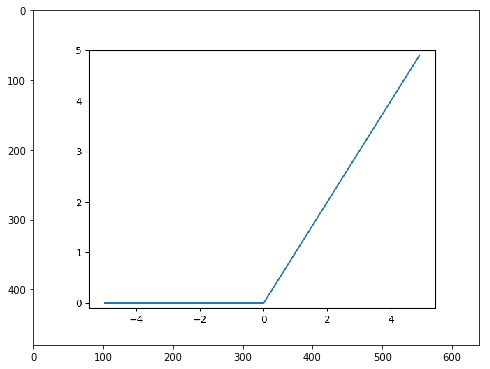

In [2]:
#623：ReLUの場合の重みの初期値：ReLU (Rectified Linear Unit（ReLU (英: Rectified Linear Unit, Rectifier、正規化線形関数）)
#「Xaivierの初期値」は、活性化関数が線形であることを前提に導いている。

import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

img = imread('D:/python/deeplearning/pycontent/dataset/learningtechnch014.png')
plt.figure(figsize=(8, 8)) # figureの縦横の大きさ
plt.imshow(img)

plt.show()

In [3]:
#sigmoid,tanh関数は左右対称なのでXaivierが適している。
#しかし、ReLU関数は特化した初期値が必要でKaiming Heらが推奨する[Heの初期値]が最適とされる
#前層ノード数が√2/nを標準偏差とするガウス分布を用いる。
#[Xaivier初期値]が√1/nだったことを考えると、負の領域が0になるのでより広がりを持たせることが必要となる為、目視するため倍の係数が必要になる

#活性化関数にReLUを用いた分布→標準偏差が0.01ガウス分布（以降,[std=0.01]※1)
#[Xaivier初期値],
#ReLU専用{He初期値}の準で分布を見てみる

#※1標準偏差（ひょうじゅんへんさ、英: standard deviation, SD）は、日本工業規格では、分散の正の平方根と定義している。
#データや確率変数の散らばり具合（ばらつき）を表す数値の一つ。 物理学、経済学、社会学などでも使う。

#実験結果を見ると、[std=0.01]の時、各層の活性化関数はとても小さい値になる。
#ニューラルネットワーク上を小さい値が流れるという事は逆伝播の勾配も勿論角度がつかない為、学習が進まない

#[Xaivier初期値]は層が流れるにつれ偏りが出る。その為、勾配消失が起こる

#ReLU専用{He初期値}は分布の広がりが均一になる。

===========iteration:0===========
std=0.01:2.3025024857152303
Xavier:2.301864290355581
He:2.307332589605595
===========iteration:100===========
std=0.01:2.30261722164932
Xavier:2.205355340727288
He:1.7539595082340589
===========iteration:200===========
std=0.01:2.3024407460960163
Xavier:2.0135098672233656
He:0.8337665384231474
===========iteration:300===========
std=0.01:2.3030665325327044
Xavier:1.5694739909211206
He:0.6818873982181485
===========iteration:400===========
std=0.01:2.3026178094633307
Xavier:1.010314691452813
He:0.49791846644636484
===========iteration:500===========
std=0.01:2.299067104530568
Xavier:0.7214780844719146
He:0.40371851552838256
===========iteration:600===========
std=0.01:2.303874364346676
Xavier:0.6934253526034737
He:0.41254013496594666
===========iteration:700===========
std=0.01:2.3001729423147688
Xavier:0.501356683477641
He:0.31251108872129385
===========iteration:800===========
std=0.01:2.302551327000498
Xavier:0.5288213759856951
He:0.3754539843228973


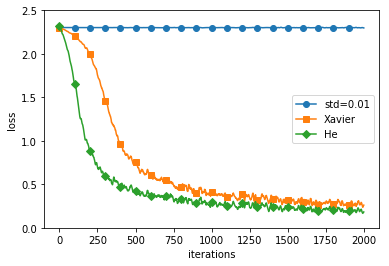

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

In [5]:
#63:batch normalization
#62で[重みの初期値]を適切に設定することで各層の活性化関数の分布は適度な広がりを持つ事が確認できた。
#次に強制的に活性化関数を調整する。


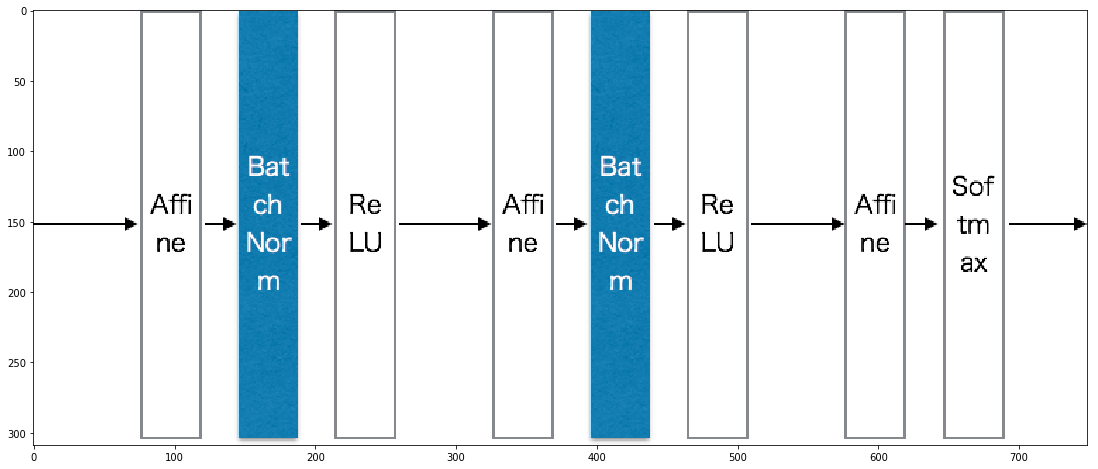

In [7]:
#63:batch normalizationアルゴリズム

#631:batch normalization(以降,#63:batch norm)は2015年に開発され機械学習コンペで優秀な結果をもたらしている。

#・学習進行の速さ(学習係数を大きく出来る)
#・初期値依存に大きく固執しない
#・過学習の抑制
#上記3点の理由が大きい。

#1つ目はディープラーニングの学習に多くの時間を割くことを避ける
#2つ目は初期値への依存度低下
#3つ目は過学習抑制効果

#batch normはそのアイディアから多く使われている。

img = imread('D:/python/deeplearning/pycontent/dataset/learningtechnch015.png')
plt.figure(figsize=(50, 8)) # figureの縦横の大きさ
plt.imshow(img)

plt.show()

In [1]:
#batch normはミニバッチを単位としてレイヤを進行しているのでミニバッチごとに正規化を行っている
#具体的にはデータ分布が平均0で、分散が1になるように正規化を行う

#          m
#μB ←1/m∑xi
#         i=1

#          m
#σ2B←1/m∑(xi-μb)^2
#         i=1

#^       
#xi←xi-μb/√σ2B+ε（イプシロン）←10e-7,0で除算されることを防止するお守りみたいなもの。

#ミニバッチとしてB={x1,x2…xm}というm個の入力データを集合に対して平均μb,分散σ^2Bを求める。
#次に入力データが平均が0、分散が1になる、適切な分布になるように正規化する。

#                                                                                   ^  ^     ^
#上記式で行っているのはミニバッチの入力データを｛x1,x2,…,xm}を平均0、分散1のデータx1,x2,…,xm}に変換するシンプルなモノである
#この処理を活性化関数の前or後に挿入することで、データ分布の偏りを減らすことが可能

#更に、Batch Normレイヤはこの正規化されたデータに対して、固有のスケールとシフトで変換を行う。数式は下記。
#       ^  
#yi = γxi+β

#γ=1、β=0はパラメ―タで学習によって適正値に調整されていく。
#以上が順伝播。逆伝播は省略するって他にも省略してるよな…。


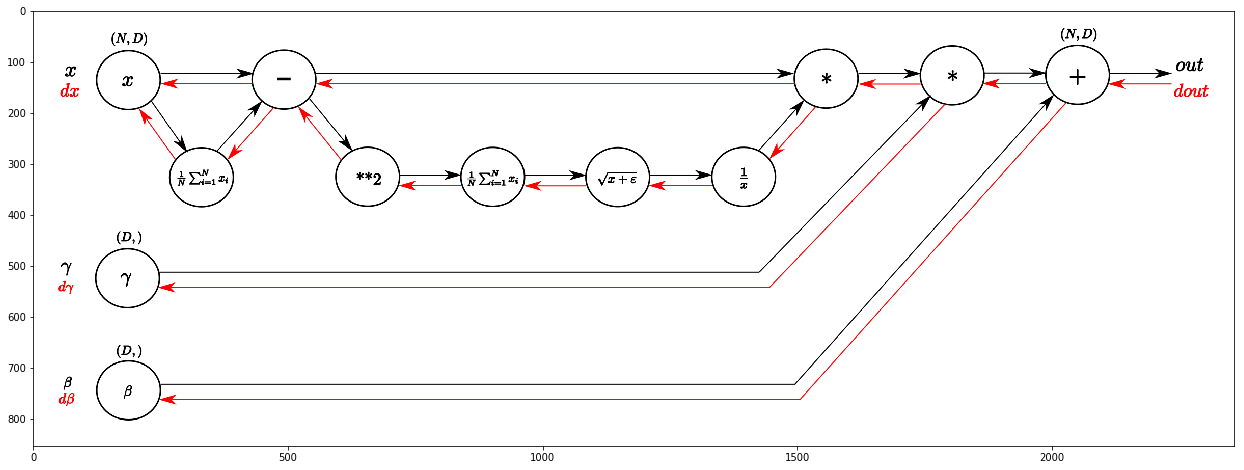

In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

img = imread('D:/python/deeplearning/pycontent/dataset/learningtechnch016.png')
plt.figure(figsize=(50, 8)) # figureの縦横の大きさ
plt.imshow(img)

plt.show()

In [4]:
#632:Batch Normalization評価


============== 1/16 ==============
epoch:0 | 0.093 - 0.114
epoch:1 | 0.097 - 0.106


D:\python\program\common\multi_layer_net_extend.py:101: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
D:\python\program\common\multi_layer_net_extend.py:101: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
D:\python\program\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
D:\python\program\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:2 | 0.097 - 0.128
epoch:3 | 0.097 - 0.14
epoch:4 | 0.097 - 0.147
epoch:5 | 0.097 - 0.159
epoch:6 | 0.097 - 0.172
epoch:7 | 0.097 - 0.187
epoch:8 | 0.097 - 0.212
epoch:9 | 0.097 - 0.234
epoch:10 | 0.097 - 0.243
epoch:11 | 0.097 - 0.265
epoch:12 | 0.097 - 0.282
epoch:13 | 0.097 - 0.301
epoch:14 | 0.097 - 0.318
epoch:15 | 0.097 - 0.327
epoch:16 | 0.097 - 0.34
epoch:17 | 0.097 - 0.352


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.363
epoch:19 | 0.097 - 0.373
============== 2/16 ==============
epoch:0 | 0.087 - 0.095
epoch:1 | 0.097 - 0.089
epoch:2 | 0.097 - 0.108
epoch:3 | 0.097 - 0.136
epoch:4 | 0.097 - 0.155
epoch:5 | 0.097 - 0.175
epoch:6 | 0.097 - 0.21
epoch:7 | 0.097 - 0.235
epoch:8 | 0.097 - 0.264
epoch:9 | 0.097 - 0.276
epoch:10 | 0.097 - 0.306
epoch:11 | 0.097 - 0.333
epoch:12 | 0.097 - 0.35
epoch:13 | 0.097 - 0.364
epoch:14 | 0.097 - 0.381
epoch:15 | 0.097 - 0.394
epoch:16 | 0.097 - 0.403
epoch:17 | 0.097 - 0.43


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.445
epoch:19 | 0.097 - 0.454
============== 3/16 ==============
epoch:0 | 0.204 - 0.115
epoch:1 | 0.377 - 0.08
epoch:2 | 0.55 - 0.149
epoch:3 | 0.629 - 0.184
epoch:4 | 0.695 - 0.24
epoch:5 | 0.759 - 0.289
epoch:6 | 0.804 - 0.335
epoch:7 | 0.826 - 0.371
epoch:8 | 0.86 - 0.399
epoch:9 | 0.89 - 0.433
epoch:10 | 0.908 - 0.459
epoch:11 | 0.931 - 0.49
epoch:12 | 0.933 - 0.511
epoch:13 | 0.942 - 0.53
epoch:14 | 0.949 - 0.554
epoch:15 | 0.959 - 0.575
epoch:16 | 0.96 - 0.589
epoch:17 | 0.973 - 0.598


No handles with labels found to put in legend.


epoch:18 | 0.976 - 0.622
epoch:19 | 0.98 - 0.638
============== 4/16 ==============
epoch:0 | 0.111 - 0.098
epoch:1 | 0.255 - 0.114
epoch:2 | 0.386 - 0.154
epoch:3 | 0.488 - 0.232
epoch:4 | 0.562 - 0.29
epoch:5 | 0.607 - 0.337
epoch:6 | 0.65 - 0.395
epoch:7 | 0.696 - 0.453
epoch:8 | 0.706 - 0.48
epoch:9 | 0.735 - 0.545
epoch:10 | 0.755 - 0.576
epoch:11 | 0.776 - 0.594
epoch:12 | 0.785 - 0.63
epoch:13 | 0.807 - 0.656
epoch:14 | 0.819 - 0.669
epoch:15 | 0.831 - 0.702
epoch:16 | 0.841 - 0.718
epoch:17 | 0.839 - 0.739
epoch:18 | 0.858 - 0.76


No handles with labels found to put in legend.


epoch:19 | 0.868 - 0.776
============== 5/16 ==============
epoch:0 | 0.051 - 0.076
epoch:1 | 0.056 - 0.121
epoch:2 | 0.067 - 0.265
epoch:3 | 0.071 - 0.418
epoch:4 | 0.081 - 0.513
epoch:5 | 0.087 - 0.592
epoch:6 | 0.117 - 0.643
epoch:7 | 0.141 - 0.681
epoch:8 | 0.156 - 0.718
epoch:9 | 0.161 - 0.749
epoch:10 | 0.183 - 0.767
epoch:11 | 0.189 - 0.779
epoch:12 | 0.193 - 0.793
epoch:13 | 0.199 - 0.804
epoch:14 | 0.206 - 0.821
epoch:15 | 0.21 - 0.844
epoch:16 | 0.215 - 0.849
epoch:17 | 0.221 - 0.87
epoch:18 | 0.227 - 0.874


No handles with labels found to put in legend.


epoch:19 | 0.226 - 0.881
============== 6/16 ==============
epoch:0 | 0.1 - 0.094
epoch:1 | 0.127 - 0.138
epoch:2 | 0.117 - 0.479
epoch:3 | 0.116 - 0.623
epoch:4 | 0.116 - 0.71
epoch:5 | 0.116 - 0.761
epoch:6 | 0.116 - 0.796
epoch:7 | 0.116 - 0.82
epoch:8 | 0.116 - 0.844
epoch:9 | 0.116 - 0.864
epoch:10 | 0.116 - 0.873
epoch:11 | 0.116 - 0.888
epoch:12 | 0.116 - 0.905
epoch:13 | 0.116 - 0.916
epoch:14 | 0.116 - 0.919
epoch:15 | 0.116 - 0.929
epoch:16 | 0.121 - 0.931
epoch:17 | 0.144 - 0.937
epoch:18 | 0.123 - 0.945


No handles with labels found to put in legend.


epoch:19 | 0.148 - 0.954
============== 7/16 ==============
epoch:0 | 0.1 - 0.128
epoch:1 | 0.117 - 0.313
epoch:2 | 0.117 - 0.634
epoch:3 | 0.117 - 0.746
epoch:4 | 0.117 - 0.791
epoch:5 | 0.117 - 0.837
epoch:6 | 0.117 - 0.855
epoch:7 | 0.117 - 0.881
epoch:8 | 0.117 - 0.9
epoch:9 | 0.117 - 0.921
epoch:10 | 0.117 - 0.933
epoch:11 | 0.117 - 0.944
epoch:12 | 0.117 - 0.955
epoch:13 | 0.117 - 0.963
epoch:14 | 0.117 - 0.964
epoch:15 | 0.117 - 0.969
epoch:16 | 0.117 - 0.973
epoch:17 | 0.117 - 0.976
epoch:18 | 0.117 - 0.983

No handles with labels found to put in legend.



epoch:19 | 0.117 - 0.988
============== 8/16 ==============
epoch:0 | 0.117 - 0.134
epoch:1 | 0.117 - 0.477
epoch:2 | 0.117 - 0.682
epoch:3 | 0.117 - 0.728
epoch:4 | 0.117 - 0.777
epoch:5 | 0.117 - 0.812
epoch:6 | 0.117 - 0.842
epoch:7 | 0.117 - 0.866
epoch:8 | 0.117 - 0.895
epoch:9 | 0.117 - 0.909
epoch:10 | 0.117 - 0.958
epoch:11 | 0.117 - 0.974
epoch:12 | 0.117 - 0.986
epoch:13 | 0.117 - 0.99
epoch:14 | 0.117 - 0.99
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.995
epoch:17 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.996
epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.117 - 0.085
epoch:1 | 0.099 - 0.502
epoch:2 | 0.116 - 0.647
epoch:3 | 0.116 - 0.714
epoch:4 | 0.116 - 0.767
epoch:5 | 0.116 - 0.827
epoch:6 | 0.116 - 0.885
epoch:7 | 0.116 - 0.93
epoch:8 | 0.116 - 0.959
epoch:9 | 0.116 - 0.981
epoch:10 | 0.116 - 0.986
epoch:11 | 0.116 - 0.993
epoch:12 | 0.116 - 0.999
epoch:13 | 0.116 - 0.999
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:18 | 0.116 - 1.0
epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.092 - 0.094
epoch:1 | 0.117 - 0.573
epoch:2 | 0.117 - 0.809
epoch:3 | 0.117 - 0.863
epoch:4 | 0.117 - 0.891
epoch:5 | 0.117 - 0.935
epoch:6 | 0.117 - 0.954
epoch:7 | 0.117 - 0.844
epoch:8 | 0.117 - 0.98
epoch:9 | 0.117 - 0.984
epoch:10 | 0.117 - 0.989
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.992
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.999
epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.099 - 0.094
epoch:1 | 0.116 - 0.624
epoch:2 | 0.117 - 0.671
epoch:3 | 0.116 - 0.801
epoch:4 | 0.116 - 0.828
epoch:5 | 0.116 - 0.836
epoch:6 | 0.116 - 0.861
epoch:7 | 0.116 - 0.899
epoch:8 | 0.116 - 0.956
epoch:9 | 0.116 - 0.943
epoch:10 | 0.116 - 0.934
epoch:11 | 0.116 - 0.969
epoch:12 | 0.116 - 0.989
epoch:13 | 0.116 - 0.958
epoch:14 | 0.116 - 0.971
epoch:15 | 0.116 - 0.99
epoch:16 | 0.116 - 0.988
epoch:17 | 0.116 - 0.995


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.987
epoch:19 | 0.116 - 0.99
============== 12/16 ==============
epoch:0 | 0.092 - 0.109
epoch:1 | 0.116 - 0.47
epoch:2 | 0.116 - 0.332
epoch:3 | 0.116 - 0.627
epoch:4 | 0.116 - 0.679
epoch:5 | 0.116 - 0.771
epoch:6 | 0.116 - 0.755
epoch:7 | 0.116 - 0.786
epoch:8 | 0.116 - 0.781
epoch:9 | 0.116 - 0.798
epoch:10 | 0.116 - 0.801
epoch:11 | 0.116 - 0.801
epoch:12 | 0.116 - 0.8
epoch:13 | 0.116 - 0.81
epoch:14 | 0.116 - 0.808
epoch:15 | 0.116 - 0.808
epoch:16 | 0.116 - 0.803
epoch:17 | 0.116 - 0.804


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.806
epoch:19 | 0.116 - 0.803
============== 13/16 ==============
epoch:0 | 0.105 - 0.135
epoch:1 | 0.116 - 0.378
epoch:2 | 0.116 - 0.41
epoch:3 | 0.116 - 0.439
epoch:4 | 0.116 - 0.482
epoch:5 | 0.116 - 0.499
epoch:6 | 0.116 - 0.503
epoch:7 | 0.116 - 0.503
epoch:8 | 0.116 - 0.508
epoch:9 | 0.117 - 0.514
epoch:10 | 0.116 - 0.515
epoch:11 | 0.116 - 0.543
epoch:12 | 0.117 - 0.556
epoch:13 | 0.116 - 0.57
epoch:14 | 0.117 - 0.534
epoch:15 | 0.116 - 0.545
epoch:16 | 0.116 - 0.608
epoch:17 | 0.117 - 0.617
epoch:18 | 0.117 - 0.618


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.736
============== 14/16 ==============
epoch:0 | 0.105 - 0.21
epoch:1 | 0.116 - 0.34
epoch:2 | 0.116 - 0.331
epoch:3 | 0.116 - 0.485
epoch:4 | 0.116 - 0.495
epoch:5 | 0.116 - 0.501
epoch:6 | 0.116 - 0.506
epoch:7 | 0.117 - 0.487
epoch:8 | 0.116 - 0.511
epoch:9 | 0.116 - 0.486
epoch:10 | 0.116 - 0.512
epoch:11 | 0.116 - 0.514
epoch:12 | 0.116 - 0.519
epoch:13 | 0.116 - 0.516
epoch:14 | 0.116 - 0.517
epoch:15 | 0.116 - 0.514
epoch:16 | 0.116 - 0.52
epoch:17 | 0.116 - 0.519
epoch:18 | 0.116 - 0.524


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.531
============== 15/16 ==============
epoch:0 | 0.116 - 0.155
epoch:1 | 0.099 - 0.315
epoch:2 | 0.117 - 0.384
epoch:3 | 0.117 - 0.416
epoch:4 | 0.117 - 0.419
epoch:5 | 0.117 - 0.426
epoch:6 | 0.117 - 0.423
epoch:7 | 0.117 - 0.43
epoch:8 | 0.117 - 0.425
epoch:9 | 0.117 - 0.477
epoch:10 | 0.117 - 0.525
epoch:11 | 0.117 - 0.519
epoch:12 | 0.117 - 0.519
epoch:13 | 0.117 - 0.515
epoch:14 | 0.117 - 0.517
epoch:15 | 0.117 - 0.524
epoch:16 | 0.117 - 0.528
epoch:17 | 0.117 - 0.532
epoch:18 | 0.117 - 0.527


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.529
============== 16/16 ==============
epoch:0 | 0.116 - 0.116
epoch:1 | 0.116 - 0.187
epoch:2 | 0.116 - 0.277
epoch:3 | 0.116 - 0.302
epoch:4 | 0.116 - 0.307
epoch:5 | 0.116 - 0.341
epoch:6 | 0.116 - 0.388
epoch:7 | 0.116 - 0.381
epoch:8 | 0.116 - 0.407
epoch:9 | 0.116 - 0.409
epoch:10 | 0.116 - 0.412
epoch:11 | 0.116 - 0.406
epoch:12 | 0.116 - 0.393
epoch:13 | 0.117 - 0.412
epoch:14 | 0.117 - 0.416
epoch:15 | 0.117 - 0.42
epoch:16 | 0.117 - 0.421
epoch:17 | 0.117 - 0.422
epoch:18 | 0.117 - 0.42
epoch:19 | 0.117 - 0.425


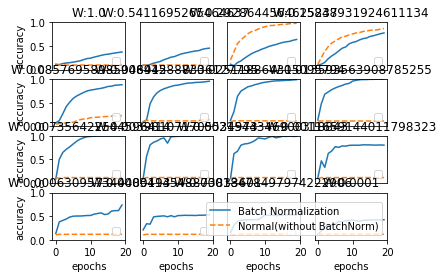

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


In [6]:
#64正規化
#過学習とは、訓練データだけに適応しすぎてしまい、訓練データに含まれない他のデータには上手く対応できない状態を指す。

#641：過学習要因
#・パラメータを大量に持っている。表現力が逆に高くなっている。
#・訓練データが少ない


epoch:0, train acc:0.11, test acc:0.1029
epoch:1, train acc:0.13, test acc:0.1179
epoch:2, train acc:0.15, test acc:0.1332
epoch:3, train acc:0.19, test acc:0.1566
epoch:4, train acc:0.24333333333333335, test acc:0.1788
epoch:5, train acc:0.2866666666666667, test acc:0.2051
epoch:6, train acc:0.30333333333333334, test acc:0.2223
epoch:7, train acc:0.33666666666666667, test acc:0.2478
epoch:8, train acc:0.37333333333333335, test acc:0.2702
epoch:9, train acc:0.36666666666666664, test acc:0.2826
epoch:10, train acc:0.38333333333333336, test acc:0.2939
epoch:11, train acc:0.39, test acc:0.3011
epoch:12, train acc:0.38666666666666666, test acc:0.2925
epoch:13, train acc:0.4266666666666667, test acc:0.3099
epoch:14, train acc:0.45666666666666667, test acc:0.3365
epoch:15, train acc:0.44666666666666666, test acc:0.3391
epoch:16, train acc:0.48333333333333334, test acc:0.3577
epoch:17, train acc:0.49, test acc:0.3622
epoch:18, train acc:0.4866666666666667, test acc:0.3636
epoch:19, train acc:

epoch:160, train acc:0.8933333333333333, test acc:0.6998
epoch:161, train acc:0.9033333333333333, test acc:0.7008
epoch:162, train acc:0.8866666666666667, test acc:0.7038
epoch:163, train acc:0.8933333333333333, test acc:0.7071
epoch:164, train acc:0.8933333333333333, test acc:0.6988
epoch:165, train acc:0.8933333333333333, test acc:0.7076
epoch:166, train acc:0.8966666666666666, test acc:0.7046
epoch:167, train acc:0.9, test acc:0.7049
epoch:168, train acc:0.9, test acc:0.7068
epoch:169, train acc:0.9, test acc:0.7064
epoch:170, train acc:0.9033333333333333, test acc:0.7127
epoch:171, train acc:0.9066666666666666, test acc:0.7101
epoch:172, train acc:0.9033333333333333, test acc:0.7088
epoch:173, train acc:0.9033333333333333, test acc:0.7127
epoch:174, train acc:0.9033333333333333, test acc:0.708
epoch:175, train acc:0.9066666666666666, test acc:0.7093
epoch:176, train acc:0.9066666666666666, test acc:0.7132
epoch:177, train acc:0.9033333333333333, test acc:0.7083
epoch:178, train acc

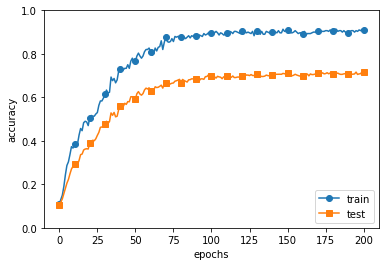

In [8]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [9]:
#上記のグラフで確認できるのは、300/60000のデータと、レイヤを7層のReLUレイヤで学習。ニューロン個数は100としている。
#上記で分かる点は信頼性（accurancy)の差


epoch:0, train acc:0.11, test acc:0.0991
epoch:1, train acc:0.13666666666666666, test acc:0.1222
epoch:2, train acc:0.19666666666666666, test acc:0.1509
epoch:3, train acc:0.24333333333333335, test acc:0.1746
epoch:4, train acc:0.26666666666666666, test acc:0.195
epoch:5, train acc:0.2833333333333333, test acc:0.2087
epoch:6, train acc:0.29333333333333333, test acc:0.225
epoch:7, train acc:0.31, test acc:0.2384
epoch:8, train acc:0.3333333333333333, test acc:0.2462
epoch:9, train acc:0.3466666666666667, test acc:0.262
epoch:10, train acc:0.36333333333333334, test acc:0.2766
epoch:11, train acc:0.3566666666666667, test acc:0.2795
epoch:12, train acc:0.37, test acc:0.2934
epoch:13, train acc:0.36666666666666664, test acc:0.2959
epoch:14, train acc:0.4033333333333333, test acc:0.3059
epoch:15, train acc:0.41333333333333333, test acc:0.3268
epoch:16, train acc:0.4266666666666667, test acc:0.3381
epoch:17, train acc:0.44, test acc:0.3407
epoch:18, train acc:0.4533333333333333, test acc:0.34

epoch:157, train acc:0.9066666666666666, test acc:0.714
epoch:158, train acc:0.9133333333333333, test acc:0.7169
epoch:159, train acc:0.9166666666666666, test acc:0.7192
epoch:160, train acc:0.91, test acc:0.7156
epoch:161, train acc:0.9133333333333333, test acc:0.7211
epoch:162, train acc:0.9166666666666666, test acc:0.7214
epoch:163, train acc:0.9166666666666666, test acc:0.723
epoch:164, train acc:0.91, test acc:0.7186
epoch:165, train acc:0.9133333333333333, test acc:0.7219
epoch:166, train acc:0.92, test acc:0.72
epoch:167, train acc:0.9133333333333333, test acc:0.717
epoch:168, train acc:0.9166666666666666, test acc:0.7212
epoch:169, train acc:0.9133333333333333, test acc:0.7213
epoch:170, train acc:0.9166666666666666, test acc:0.721
epoch:171, train acc:0.91, test acc:0.7194
epoch:172, train acc:0.9166666666666666, test acc:0.7151
epoch:173, train acc:0.93, test acc:0.7198
epoch:174, train acc:0.9266666666666666, test acc:0.7212
epoch:175, train acc:0.9233333333333333, test acc:

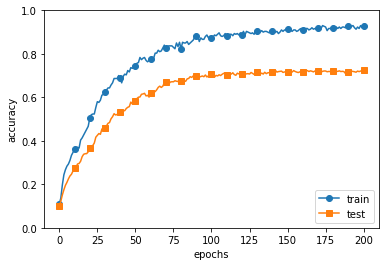

In [10]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

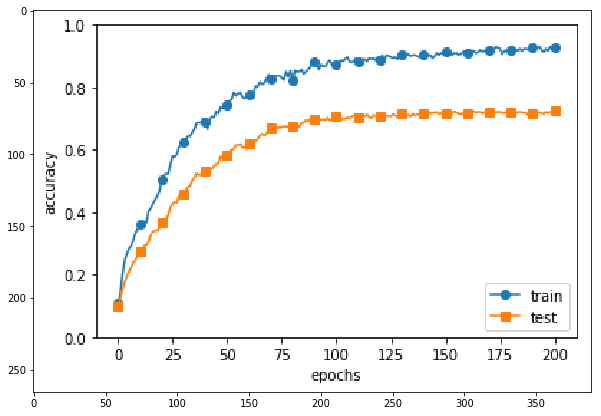

In [12]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

img = imread('D:/python/deeplearning/pycontent/dataset/learningtechnch017.png')
plt.figure(figsize=(10, 8)) # figureの縦横の大きさ
plt.imshow(img)

plt.show()

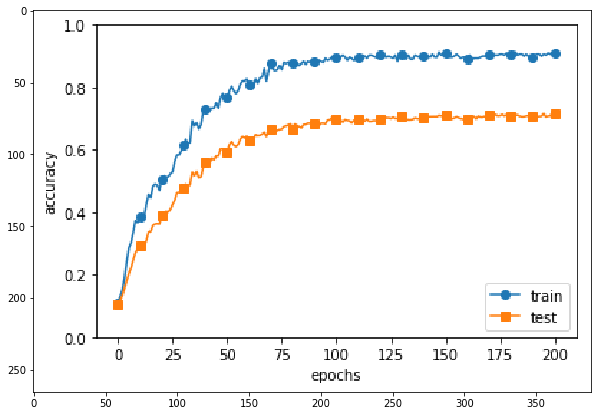

In [13]:
#↑加重衰減版
img = imread('D:/python/deeplearning/pycontent/dataset/learningtechnch018.png')
plt.figure(figsize=(10, 8)) # figureの縦横の大きさ
plt.imshow(img)

plt.show()
#↓加重衰減

train loss:2.317433622774436
=== epoch:1, train acc:0.08666666666666667, test acc:0.0864 ===
train loss:2.303597196402965
train loss:2.3027206287279274
train loss:2.301096193916634
=== epoch:2, train acc:0.08666666666666667, test acc:0.0891 ===
train loss:2.307794079031168
train loss:2.3045742330525565
train loss:2.2865357666411565
=== epoch:3, train acc:0.09, test acc:0.0919 ===
train loss:2.3080431556041385
train loss:2.2949298630830937
train loss:2.2668437362594265
=== epoch:4, train acc:0.09333333333333334, test acc:0.094 ===
train loss:2.3064676676916678
train loss:2.2955782154419335
train loss:2.285052025190892
=== epoch:5, train acc:0.09, test acc:0.0968 ===
train loss:2.290057672349005
train loss:2.298914367556785
train loss:2.292732355608865
=== epoch:6, train acc:0.09333333333333334, test acc:0.1001 ===
train loss:2.30709259449392
train loss:2.2866140609513312
train loss:2.293437547473157
=== epoch:7, train acc:0.1, test acc:0.0989 ===
train loss:2.2861396736350064
train loss

=== epoch:56, train acc:0.27666666666666667, test acc:0.2108 ===
train loss:2.2320810558927944
train loss:2.238484649127658
train loss:2.224257651886349
=== epoch:57, train acc:0.27666666666666667, test acc:0.2146 ===
train loss:2.225011031135951
train loss:2.2266336755471023
train loss:2.2417597187289124
=== epoch:58, train acc:0.2833333333333333, test acc:0.2175 ===
train loss:2.2349058985318764
train loss:2.2324224773157177
train loss:2.266686351500776
=== epoch:59, train acc:0.2833333333333333, test acc:0.22 ===
train loss:2.2185478023797227
train loss:2.236312568081072
train loss:2.2106491718149424
=== epoch:60, train acc:0.28, test acc:0.215 ===
train loss:2.2430883231319267
train loss:2.251293450693916
train loss:2.2244607604598094
=== epoch:61, train acc:0.28, test acc:0.2204 ===
train loss:2.230422794036809
train loss:2.208655060650742
train loss:2.2233171262555054
=== epoch:62, train acc:0.2866666666666667, test acc:0.2244 ===
train loss:2.237569153698174
train loss:2.2214926

=== epoch:112, train acc:0.37666666666666665, test acc:0.2971 ===
train loss:2.116353712499776
train loss:2.091499848478824
train loss:2.116696217820782
=== epoch:113, train acc:0.37666666666666665, test acc:0.2998 ===
train loss:2.14482554889248
train loss:2.0810737241379322
train loss:2.1362190578671867
=== epoch:114, train acc:0.38333333333333336, test acc:0.3006 ===
train loss:2.176837312829654
train loss:2.117297808156314
train loss:2.117334123549131
=== epoch:115, train acc:0.38333333333333336, test acc:0.3013 ===
train loss:2.1294811686196904
train loss:2.0729874500817633
train loss:2.131190005229576
=== epoch:116, train acc:0.38333333333333336, test acc:0.3029 ===
train loss:2.126597854135431
train loss:2.1205181580961265
train loss:2.1482294477350043
=== epoch:117, train acc:0.38333333333333336, test acc:0.3046 ===
train loss:2.0600910731680613
train loss:2.1117153041843317
train loss:2.070900911897363
=== epoch:118, train acc:0.38666666666666666, test acc:0.308 ===
train loss

=== epoch:168, train acc:0.42333333333333334, test acc:0.3684 ===
train loss:1.9391023223299042
train loss:1.747953233983497
train loss:1.8396772874328422
=== epoch:169, train acc:0.42333333333333334, test acc:0.3675 ===
train loss:1.9062281974489361
train loss:1.772724872082526
train loss:1.8773895621049577
=== epoch:170, train acc:0.4266666666666667, test acc:0.3691 ===
train loss:1.9206478392802238
train loss:1.862782414804492
train loss:1.9235988899931942
=== epoch:171, train acc:0.43, test acc:0.37 ===
train loss:1.894543881958927
train loss:1.8900265817661532
train loss:1.888727205630509
=== epoch:172, train acc:0.4266666666666667, test acc:0.3715 ===
train loss:1.8314055058362992
train loss:1.8582493599610785
train loss:1.862804018156026
=== epoch:173, train acc:0.43, test acc:0.372 ===
train loss:1.7697517356414236
train loss:1.716352751727457
train loss:1.8656964569713153
=== epoch:174, train acc:0.43, test acc:0.3726 ===
train loss:1.9360794189622632
train loss:1.781471474905

=== epoch:223, train acc:0.45666666666666667, test acc:0.3911 ===
train loss:1.670218180437048
train loss:1.5446996406648381
train loss:1.5517110282052906
=== epoch:224, train acc:0.4533333333333333, test acc:0.3897 ===
train loss:1.6048993857611598
train loss:1.5865477919591087
train loss:1.5044211442763291
=== epoch:225, train acc:0.45666666666666667, test acc:0.3917 ===
train loss:1.4786042869388505
train loss:1.5126370580696085
train loss:1.4679916153807229
=== epoch:226, train acc:0.4533333333333333, test acc:0.3906 ===
train loss:1.4470785656308656
train loss:1.6003180269102522
train loss:1.7088728734590006
=== epoch:227, train acc:0.4533333333333333, test acc:0.3926 ===
train loss:1.5866749596594776
train loss:1.5290971041988406
train loss:1.4795169254482732
=== epoch:228, train acc:0.45, test acc:0.3924 ===
train loss:1.606671860081414
train loss:1.3126808354177895
train loss:1.5732054067862506
=== epoch:229, train acc:0.45, test acc:0.3947 ===
train loss:1.541255228642564
trai

=== epoch:278, train acc:0.5533333333333333, test acc:0.445 ===
train loss:1.3189757368024262
train loss:1.3593329048494922
train loss:1.3099774207703279
=== epoch:279, train acc:0.5666666666666667, test acc:0.4467 ===
train loss:1.4747867287304692
train loss:1.3518139193232266
train loss:1.3445124380963913
=== epoch:280, train acc:0.5733333333333334, test acc:0.4492 ===
train loss:1.3379671173931806
train loss:1.2761716076628673
train loss:1.2417844401797624
=== epoch:281, train acc:0.5766666666666667, test acc:0.451 ===
train loss:1.2505778695479282
train loss:1.192851716290473
train loss:1.3446961899718397
=== epoch:282, train acc:0.5766666666666667, test acc:0.4508 ===
train loss:1.2465949200029263
train loss:1.2492516322764755
train loss:1.401852083876388
=== epoch:283, train acc:0.58, test acc:0.4518 ===
train loss:1.2492959064581282
train loss:1.1815907883389056
train loss:1.2642907302433066
=== epoch:284, train acc:0.5733333333333334, test acc:0.45 ===
train loss:1.247481300680

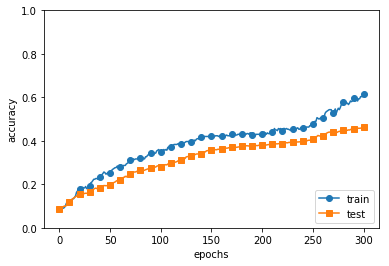

In [14]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

val acc:0.09 | lr:3.67627330411554e-05, weight decay:1.686855492203517e-08
val acc:0.24 | lr:0.0011417335056985935, weight decay:2.1409676954599475e-06
val acc:0.09 | lr:5.815504167345218e-05, weight decay:2.8873491698368695e-07
val acc:0.51 | lr:0.0038192520986462374, weight decay:1.9653072097831588e-08
val acc:0.74 | lr:0.008528395654847505, weight decay:4.889503847175782e-08
val acc:0.09 | lr:2.8160294299393495e-06, weight decay:1.7605457520649633e-07
val acc:0.6 | lr:0.0035572285632159513, weight decay:7.589532452957474e-06
val acc:0.75 | lr:0.008005473762055999, weight decay:6.031824922371858e-06
val acc:0.09 | lr:2.9926650066405154e-06, weight decay:4.1427136376603236e-06
val acc:0.13 | lr:0.0004267811760875949, weight decay:1.1430771941014982e-06
val acc:0.18 | lr:0.0011834180376708641, weight decay:7.95602101176209e-06
val acc:0.09 | lr:1.707650558311421e-06, weight decay:8.990624478260546e-07
val acc:0.08 | lr:0.00015690846489833663, weight decay:4.6798489521003305e-07
val acc

Best-15(val acc:0.47) | lr:0.003928106529729775, weight decay:3.396707428778115e-08
Best-16(val acc:0.45) | lr:0.0015195181992530156, weight decay:1.1372457496148398e-08
Best-17(val acc:0.43) | lr:0.003129799075831201, weight decay:6.776019778853564e-07
Best-18(val acc:0.42) | lr:0.0031676088926378037, weight decay:8.232585827295542e-08
Best-19(val acc:0.41) | lr:0.0011975250681290181, weight decay:2.794719164923792e-05
Best-20(val acc:0.39) | lr:0.0024423965889472997, weight decay:5.510714009945451e-05


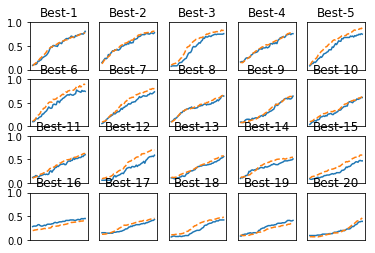

In [15]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


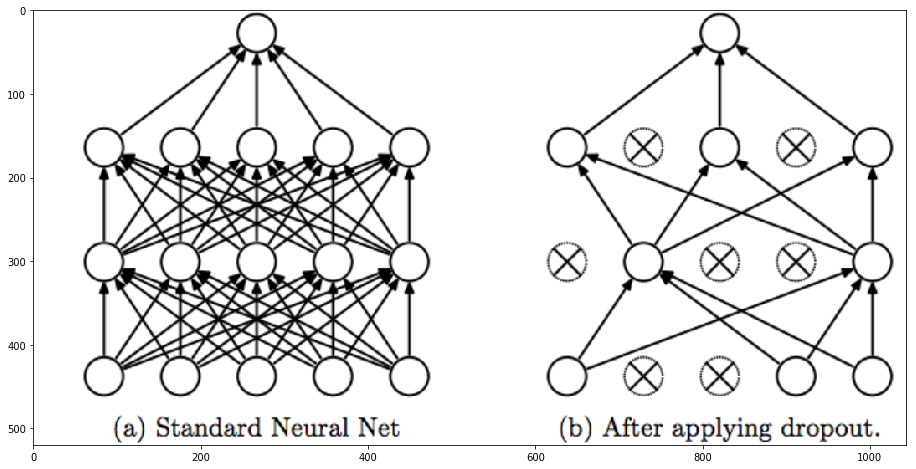

In [16]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

img = imread('D:/python/deeplearning/pycontent/dataset/learningtechnch019.png')
plt.figure(figsize=(50, 8)) # figureの縦横の大きさ
plt.imshow(img)

plt.show()


In [17]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
    """損失関数のグラフを滑らかにするために用いる

    参考：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """データセットのシャッフルを行う

    Parameters
    ----------
    x : 訓練データ
    t : 教師データ

    Returns
    -------
    x, t : シャッフルを行った訓練データと教師データ
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

val acc:0.15 | lr:0.00017471906212958055, weight decay:2.051853596252225e-07
val acc:0.1 | lr:8.218419869015017e-05, weight decay:1.6213757077847202e-06
val acc:0.09 | lr:8.551676481548289e-05, weight decay:1.7329386202149938e-07
val acc:0.07 | lr:2.96482695135896e-05, weight decay:1.540683273274754e-05
val acc:0.07 | lr:3.7739172400485183e-06, weight decay:7.197587053849192e-05
val acc:0.08 | lr:4.791509030335954e-05, weight decay:1.534486814524194e-06
val acc:0.11 | lr:8.189866200674484e-05, weight decay:7.552424496337866e-05
val acc:0.12 | lr:2.1449407522824554e-06, weight decay:2.5455392575224708e-08
val acc:0.08 | lr:0.00015718155796502303, weight decay:1.4403549726438742e-08
val acc:0.09 | lr:4.376235581141819e-06, weight decay:5.634506613895634e-05
val acc:0.21 | lr:6.17124929258257e-05, weight decay:5.933093495319703e-05
val acc:0.15 | lr:0.0003902320144280339, weight decay:4.475159080437485e-05
val acc:0.09 | lr:1.2550517692685958e-06, weight decay:1.4551615756069844e-07
val a

Best-14(val acc:0.48) | lr:0.0034866809433742258, weight decay:3.975848058875868e-05
Best-15(val acc:0.47) | lr:0.0024917339870830385, weight decay:4.584911970969952e-06
Best-16(val acc:0.43) | lr:0.0037652964249572365, weight decay:3.0366978808315424e-06
Best-17(val acc:0.42) | lr:0.0023690621531725488, weight decay:2.2662475752437681e-07
Best-18(val acc:0.4) | lr:0.0019779080853723797, weight decay:4.378309508012744e-08
Best-19(val acc:0.37) | lr:0.0011491331928327566, weight decay:4.484631829258554e-07
Best-20(val acc:0.36) | lr:0.001422264903091174, weight decay:2.4331600987905373e-08


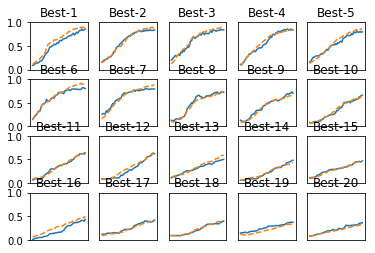

In [18]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


In [19]:
#まとめ
#パラメータの更新方法には,SGDのほかに、有名なものとして、MomentumやAdaGrad等の手法がある。
#重みの初期値の与え方は正しい学習を行ううえで非常に重要
#重みの初期値として[Xavierの初期値]、[Heの初期値]等が有効
#Batch Normalizationを用いることで、学習を早く進めることが可能
#初期値に対してロバストになる
#過学習を抑制するための正規化の技術としてWeight decayやDropoutがある
#ハイパーパラメータの探索はいい値が存在する範囲を徐々に絞りながら進めるのが効率的な方法。

#※ロバストネスまたはロバスト性とは、ある系が応力や環境の変化といった外乱の影響によって変化することを阻止する内的な仕組み、または性質のこと。
#ロバストネスを持つような設計をロバスト設計、ロバストネスを最適化することをロバスト最適化という。
#ロバスト（英語表記）robust
#①  頑健なこと。がっしりしていること。また、確固としていること。
#②  コンピューターのプログラムが、起こったエラーに自動的に対処して処理を続行すること。

In [ ]:
#6章自体が他で調べてくれがすごく多くなったなって思って改めて最初から見てみると近年の方法だから、
#本に載せるよりもポイントだけ選択したって感じに見える。
#要は此処で学習するよりももっと広がりがあるかもしれないというメッセージ。。。なんてことはあるまい。

#なのでもう一回纏めてき